# Gap Analysis Step 2: Calculate the Turbine Ideal Energy

In [1]:
%load_ext autoreload
%autoreload 2

This notebook provides an overview and walk-through of the turbine ideal energy (TIE) method in OpenOA. The TIE metric is defined as the amount of electricity generated by all turbines at a wind farm operating under normal conditions (i.e., not subject to downtime or significant underperformance, but subject to wake losses and moderate turbine performance losses). The approach to calculate TIE is to:

1. Filter out underperforming data from the power curve for each turbine,
2. Develop a statistical relationship between the remaining power data and key atmospheric variables from a long-term    reanalysis product
3. Long-term correct the period of record power data using the above statistical relationship
4. Sum up the long-term corrected power data across all turbines to get TIE for the wind farm

Here we use different reanalysis products to capture the uncertainty around the modeled wind resource. We also consider uncertainty due to power data accuracy and the power curve filtering choices for identifying normal turbine performance made by the analyst.

In this example, the process for estimating TIE is illustrated both with and without uncertainty quantification.

In [2]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openoa.analysis import TurbineLongTermGrossEnergy
from openoa.utils import plot

import project_ENGIE

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/data/la_haute_borne' folder

In [3]:
# Load plant object and validate for the turbine long term energy analysis type
project = project_ENGIE.prepare('./data/la_haute_borne', use_cleansed=False)
project.analysis_type.append("TurbineLongTermGrossEnergy")
project.validate()

In [4]:
# Let's take a look at the columns in the SCADA data frame
project.scada.head()

WROT_BlPthAngVal     WTUR_W  WMET_HorWdSpd  \
time                asset_id                                               
2014-01-01 00:00:00 R80736               -1.00  642.78003           7.12   
                    R80721               -1.01  441.06000           6.39   
                    R80790               -0.96  658.53003           7.11   
                    R80711               -0.93  514.23999           6.87   
2014-01-01 00:10:00 R80790               -0.96  640.23999           7.01   

                              WMET_HorWdDirRel  WMET_EnvTmp     Ya_avg  \
time                asset_id                                             
2014-01-01 00:00:00 R80736                0.66         4.69  181.34000   
                    R80721               -2.48         4.94  179.82001   
                    R80790                1.07         4.55  172.39000   
                    R80711                6.95         4.30  172.77000   
2014-01-01 00:10:00 R80790               -1.90         4.68  172.39000   

                              WMET_HorWdDir  energy_kwh  WTUR_SupWh  
time                asset_id                                         
2014-01-01 00:00:00 R80736        182.00999  107.130005  107.130005  
                    R80721        177.36000   73.510000   73.510000  
                    R80790        173.50999  109.755005  109.755005  
                    R80711        179.72000   85.706665   85.706665  
2014-01-01 00:10:00 R80790        170.46001  106.706665  106.706665

## TIE calculation without uncertainty quantification

Next we create a TIE object which will contain the analysis to be performed. The method has the ability to calculate uncertainty in the TIE metric through a Monte Carlo sampling of filtering thresholds, power data, and reanalysis product choices. For now, we turn this option off and run the method a single time.

**NOTE**: The inputs `wind_bin_threshold`, `max_power_filter`, and `correction_threshold` all default to UQ inputs, and so inputs must be provided to these parameters when running a single case (`UQ=False`).

In [5]:
ta = TurbineLongTermGrossEnergy(
    project,
    UQ=False,
    wind_bin_threshold=2.0,  # Exclude data outside 2 standard deviations of the median for each power bin
    max_power_filter=0.9,  # Don't apply bin filter above 0.9 of turbine capacity
    correction_threshold=0.9  # Set the correction threshold to 90%
)

All of the steps in the TI calculation process are pulled under a single run() function. These steps include:

1. Processing reanalysis data to daily averages.
2. Filtering the SCADA data
3. Fitting the daily reanalysis data to daily SCADA data using a Generalized Additive Model (GAM)
4. Apply GAM results to calculate long-term TIE for the wind farm

By setting `UQ=False` (the default argument value), we must manually specify key filtering thresholds that would otherwise be sampled from a range of values through Monte Carlo. Specifically, we must set thresholds applied to the bin_filter() function in the toolkits.filtering class of OpenOA. 

We also must decide how to deal with missing data when computing daily sums of energy production from each turbine. Here we set the threshold at 0.9 (i.e., if greater than 90% of SCADA data are available for a given day, scale up the daily energy by the fraction of data missing. If less than 90% data recovery, exclude that day from analysis.

Now we'll call the run() method to calculate TIE, choosing two reanalysis products to be used in the TIE calculation process.

In [6]:
# We can choose to save key plots to a file by setting enable_plotting=True and 
# specifying a directory to save the images. For now we turn off this feature. 
# ta.run(reanalysis_subset=['era5', 'merra2'], enable_plotting=False, plot_dir=None,
#        wind_bin_thresh=wind_bin_thresh, max_power_filter=max_power_filter,
#        correction_threshold=correction_threshold)
ta.run(reanalysis_products=['era5', 'merra2'])

100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.30s/it]


Now that we've finished the TIE calculation, let's examine results

In [7]:
ta.plant_gross

array([[13513603.02263866],
       [13569908.81568854]])

In [8]:
# What is the long-term annual TIE for whole plant
print(f"Long-term turbine ideal energy is {np.mean(ta.plant_gross / 1e6):0,.1f} GWh/year")

Long-term turbine ideal energy is 13.5 GWh/year


The long-term TIE value of 13.6 GWh/year is based on the mean TIE resulting from the two reanalysis products considered.

Next, we can examine how well the filtering worked by examining the power curves for each turbine using the plot_filtered_power_curves() function.

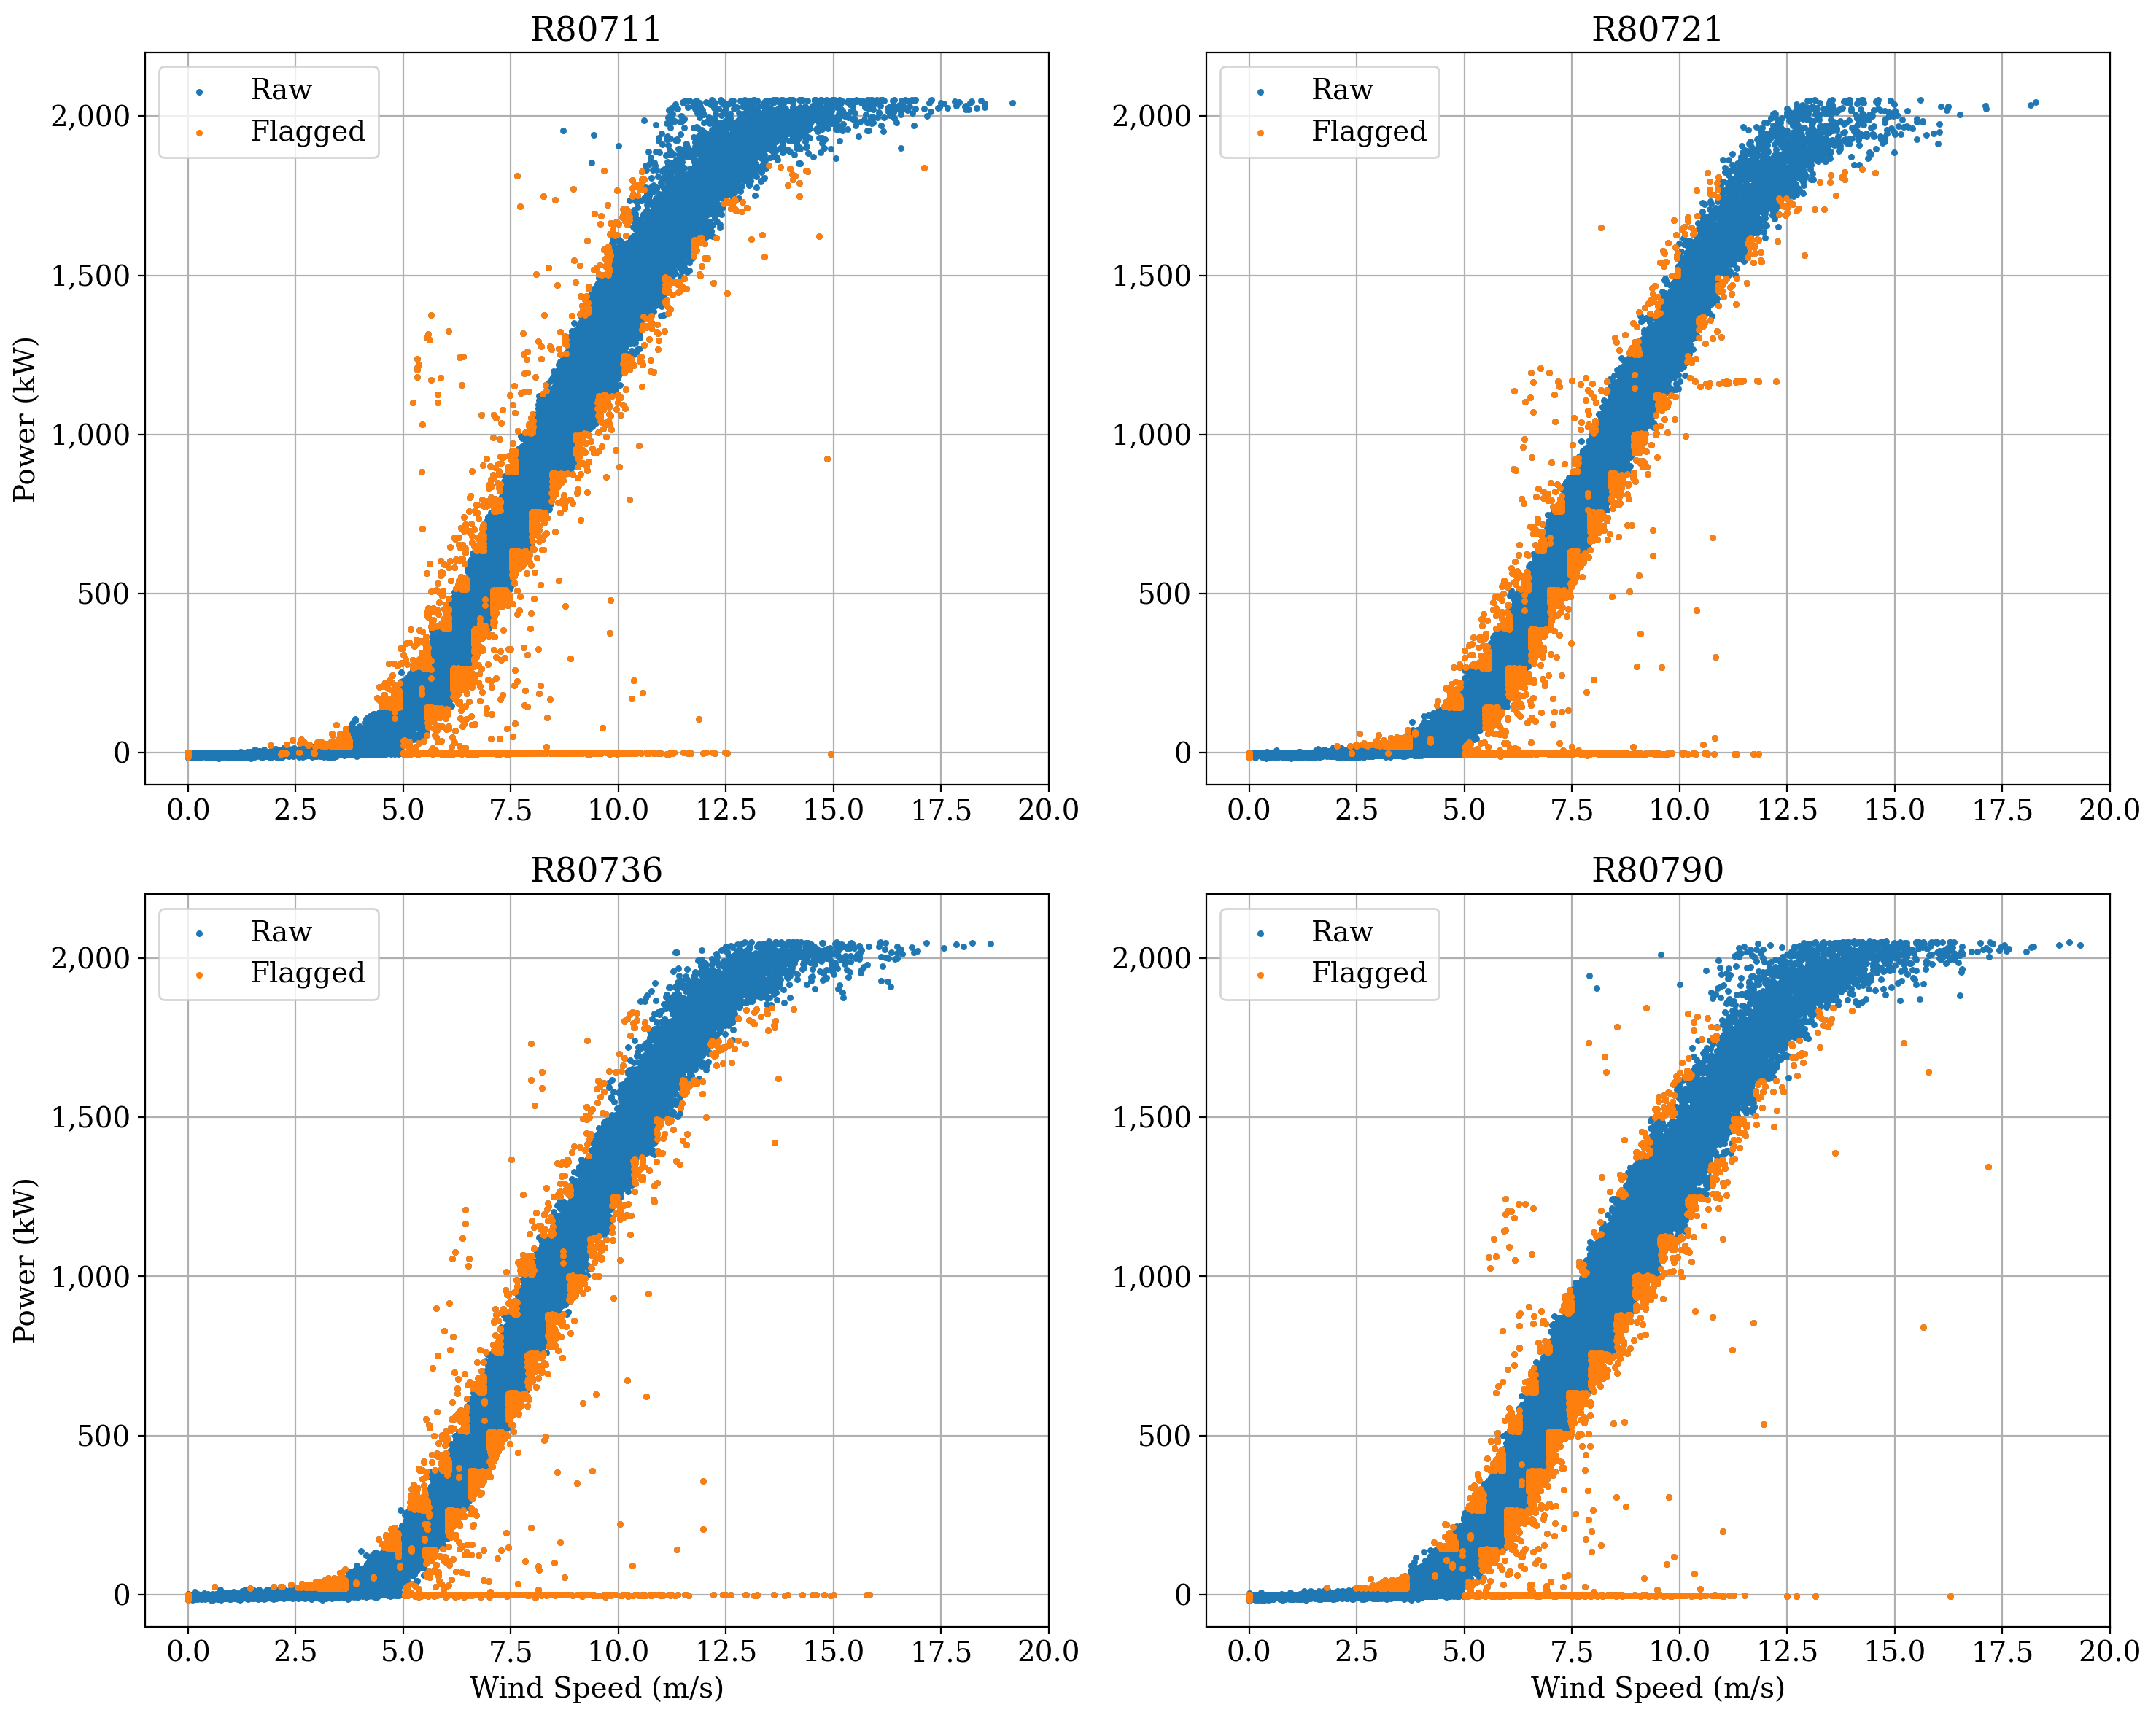

In [9]:
ta.plot_filtered_power_curves(
    flag_labels=("Flagged", "Raw"),
    legend=True,
    max_cols=2,
    xlim=(-1, 20),
    ylim=(-100, 2200),
    figure_kwargs=dict(figsize=(15, 12)),
    plot_kwargs=dict(s=5),
)

# # Alternatively, using the plotting library
# plot.plot_power_curves(
#     data=ta.scada_dict,
#     windspeed_col="windspeed",
#     power_col="power",
#     flag_col="flag_final",
#     flag_labels=("Flagged", "Raw"),
#     legend=True,
#     max_cols=2,
#     xlim=(-1, 20),
#     ylim=(-100, 2200),
#     figure_kwargs=dict(figsize=(15, 12)),
#     plot_kwargs=dict(s=5),
# )

Overall these are very clean power curves, and the filtering algorithms seem to have done a good job of catching the most egregious outliers.

Now let's look at the daily data and how well the power curve fit worked

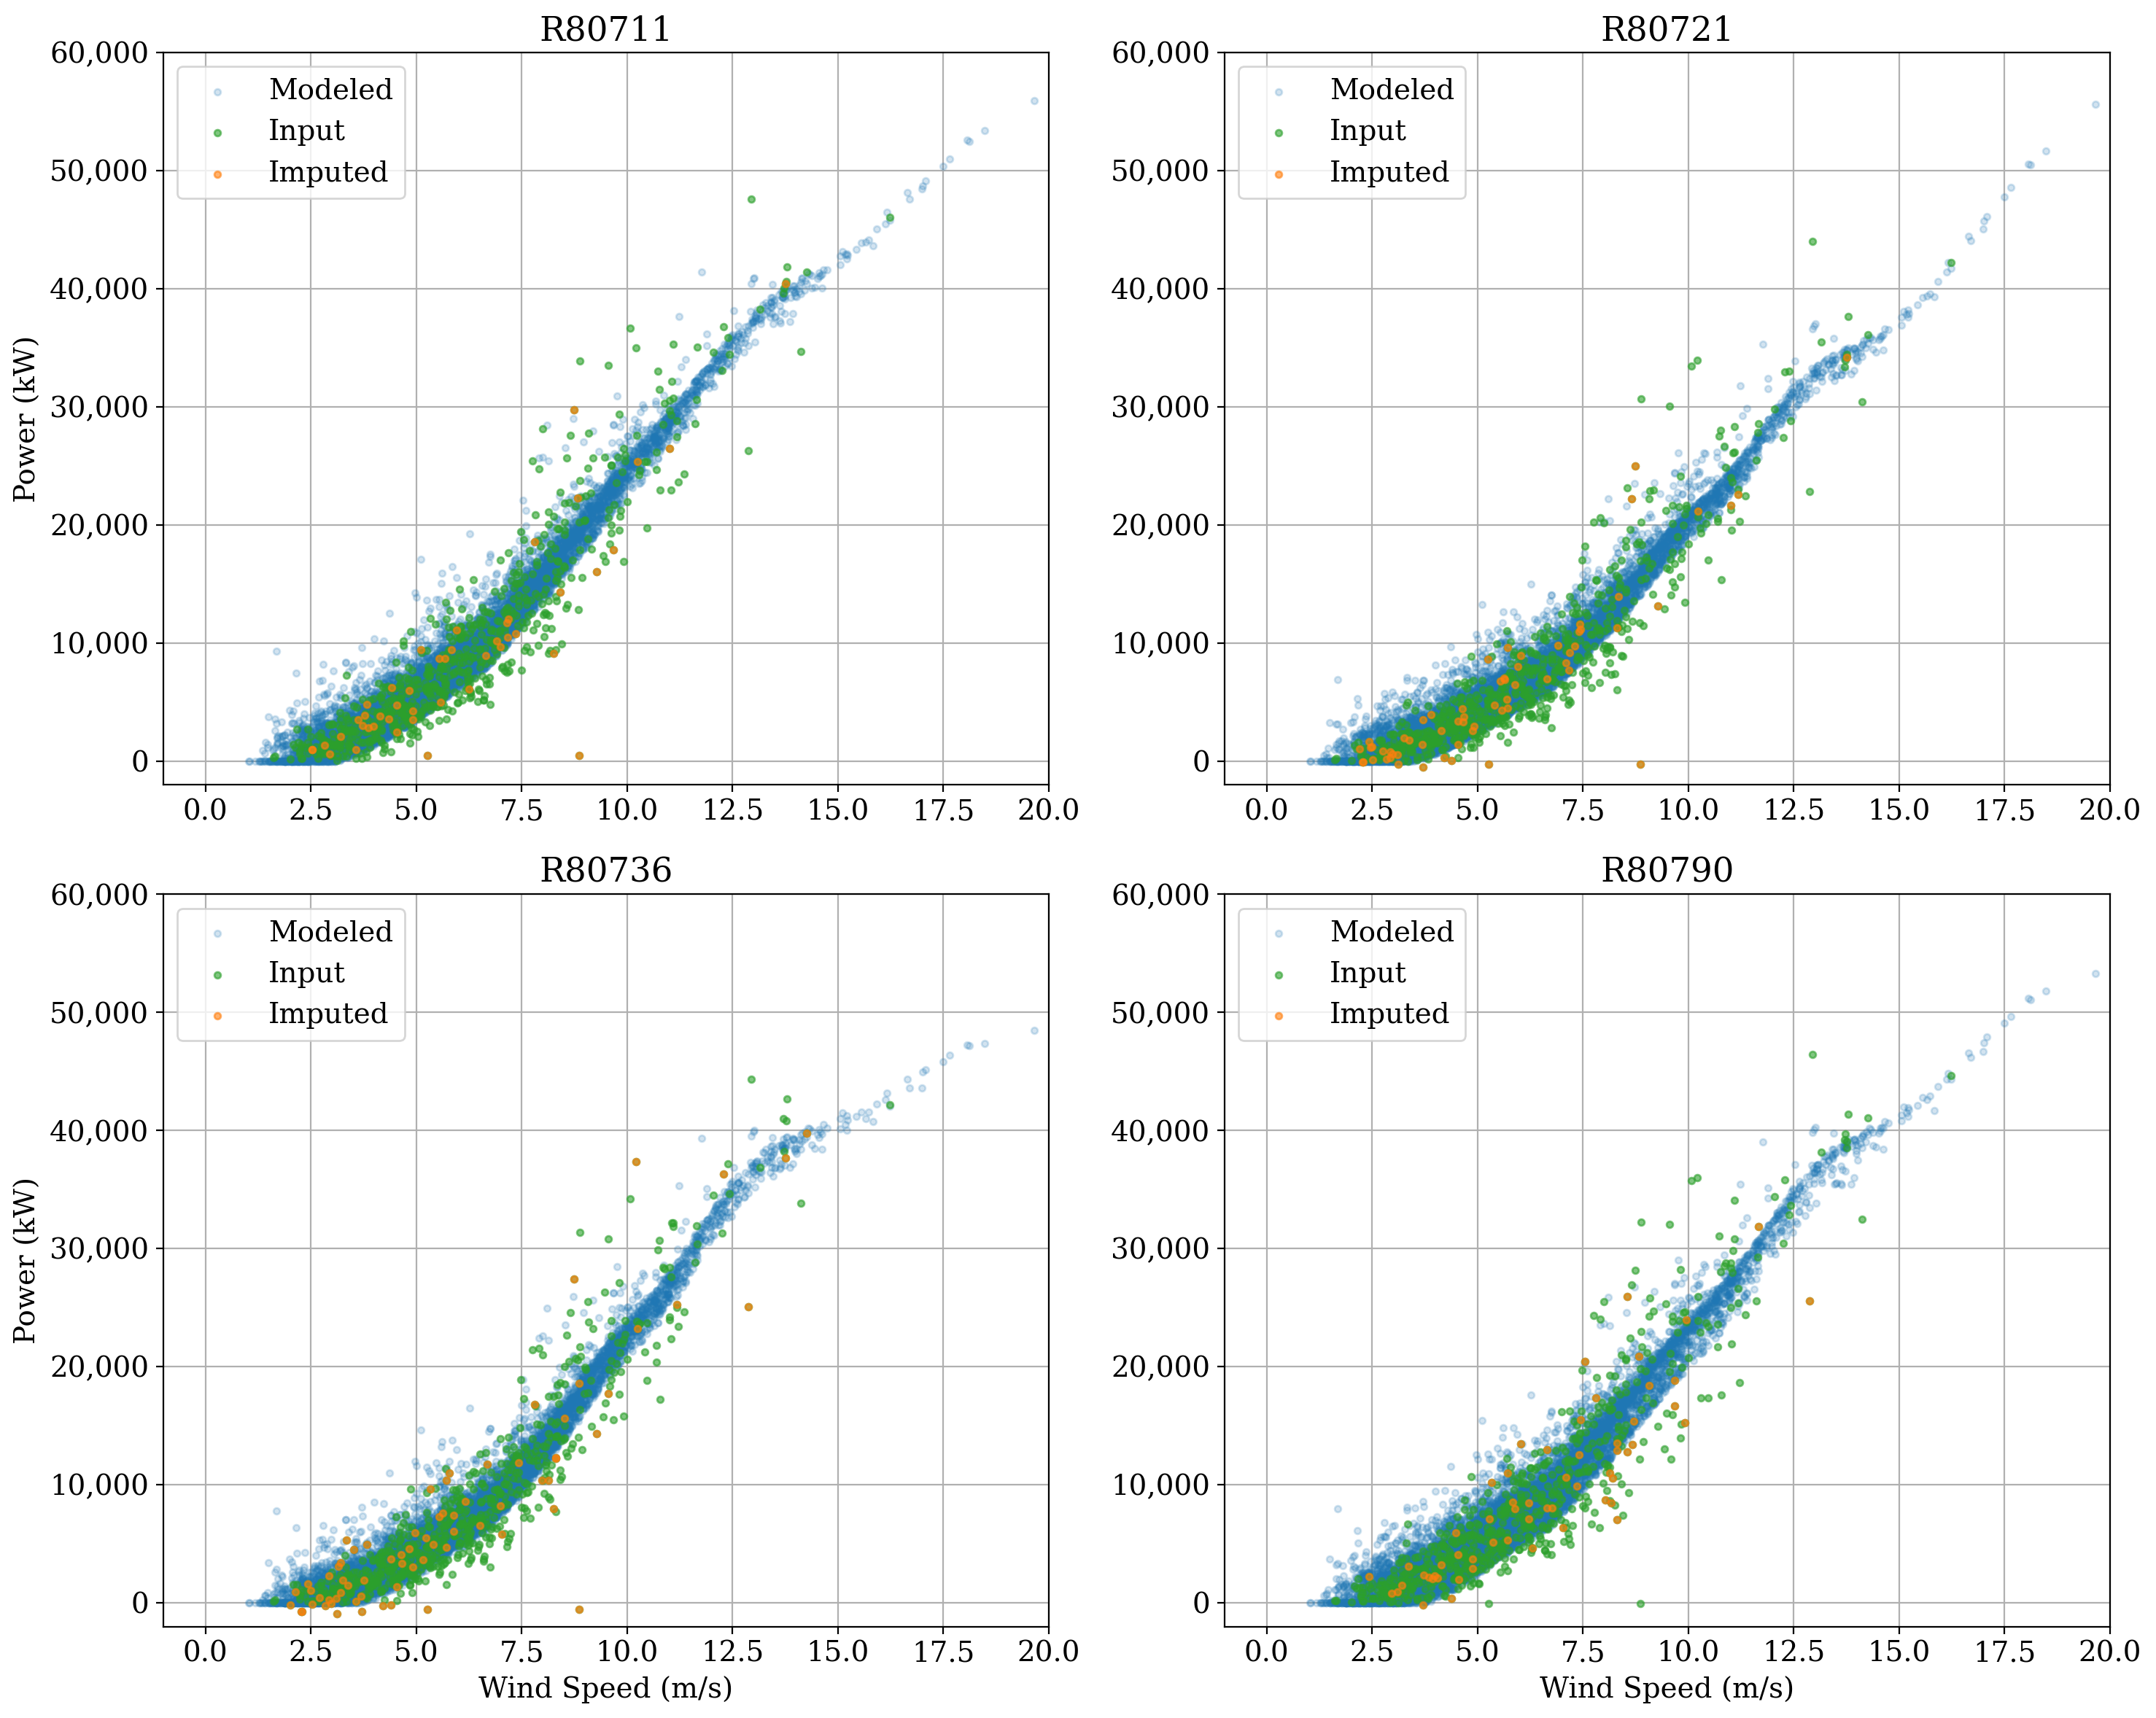

In [10]:
ta.plot_daily_fitting_result(
    legend=True,
    max_cols=2,
    xlim=(-1, 20),
    ylim=(-2000, 60000),
    plot_kwargs=dict(s=10),
    figure_kwargs=dict(figsize=(15, 12)),
)

Overall the fit looks good. The modeled data sometimes estimate higher energy at low wind speeds compared to the observed, but keep in mind the model fits to long term wind speed, wind direction, and air density, whereas we are only showing the relationship to wind speed here.

Note that 'imputed' means daily power data that were missing for a specific turbine, but were calculated by establishing statistical relationships with that turbine and its neighbors. This is necessary since a wind farm often has one turbine down and, without imputation, very little daily data would be left if we excluded days when a turbine was down.

## TIE calculation including uncertainty quantification

Now we will create a TIE object for calculating TIE and quantifying the uncertainty in our estimate. The method estimates uncertainty in the TIE metric through a Monte Carlo sampling of filtering thresholds, power data, and reanalysis product choices.

Note that we set the number of Monte Carlo simulations to only 100 in this example because of the relatively high computational effort required to perform a single iteration. In practice, a larger number of simulations is recommended (the default value is 2000).

With uncertainty quantification enabled (UQ=True), we can specify the assumed uncertainty of the SCADA power data (0.5% by default) and ranges of two key filtering thresholds from which the Monte Carlo simulations will sample. Specifically, these thresholds are applied to the bin_filter() function in the toolkits.filtering class of OpenOA.

Note that the following parameters are the default values.

In [11]:
ta=TurbineLongTermGrossEnergy(
    project,
    UQ=True,  # enable uncertainty quantification
    num_sim=100,  # number of Monte Carlo simulations to perform
    wind_bin_threshold=(1, 3),  # Data outside of a range of +-1 to +-3 standard deviations from the median for each power bin are discarded
    max_power_filter=(0.8, 0.9),  # The bin filter will be applied up to fractions of turbine capacity from 80% to 90%
    uncertainty_scada=0.005,  # Assumed uncertainty of SCADA power data (0.5%)
    correction_threshold=(0.85, 0.95),
)

We will consider a range of availability thresholds for dealing with missing data when computing daily sums of energy production from each turbine (i.e., if greater than the given threshold of SCADA data are available for a given day, scale up the daily energy by the fraction of data missing. If less than the given threshold of data are available, exclude that day from analysis. Here we set the range of thresholds as 85% to 95%. 

Now we'll call the run() method to calculate TIE with uncertainty quantification, again choosing two reanalysis products to be used in the TIE calculation process.

Note that without uncertainty quantification (UQ=False), a separate TIE value is calculated for each reanalysis product specified. However, when UQ=True, the reanalysis product is treated as another Monte Carlo sampling parameter. Thus, the impact of different reanlysis products is considered to be part of the overall uncertainty in TIE. 

In [12]:
# We can choose to save key plots to a file by setting enable_plotting=True and 
# specifying a directory to save the images. For now we turn off this feature. 
ta.run(reanalysis_products=['era5', 'merra2'])

100%|█████████████████████████████████████████| 100/100 [20:42<00:00, 12.42s/it]


Now that we've finished the Monte Carlo TIE calculation simulations, let's examine results

In [13]:
np.mean(ta.plant_gross)

13474577.755361233

In [14]:
np.std(ta.plant_gross)

493397.28161306574

In [15]:
# Mean long-term annual TIE for whole plant
print(f"Mean long-term turbine ideal energy is {np.mean(ta.plant_gross / 1e6):,.1f} GWh/year")

# Uncertainty in long-term annual TIE for whole plant
print(f"Uncertainty in long-term turbine ideal energy is {np.std(ta.plant_gross / 1e6):,.1f} GWh/year, or {np.std(ta.plant_gross) / np.mean(ta.plant_gross):.1%} percent")

Mean long-term turbine ideal energy is 13.5 GWh/year
Uncertainty in long-term turbine ideal energy is 0.5 GWh/year, or 3.7% percent



As expected, the mean long-term TIE is close to the earlier estimate without uncertainty quantification. A relatively low uncertainty has been estimated for the TIE calculations. This is a result of the relatively close agreement between the two reanalysis products and the clean power curves plotted earlier.